In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

import json

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context  # No idea what this does but it works

In [3]:
BATCH_SIZE = 32
EPOCHS = 500
IMG_SIZE = (224,224)
LABELS = ["female", "male"]

In [4]:
# Load the datasets
# In this POC, perturbed data refers to facial data processed with makeup
preprocessing_fp = "preprocessing/combined_filtered"

In [5]:
train_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "train"),
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 29026 files belonging to 2 classes.


In [6]:
validation_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "val"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 8275 files belonging to 2 classes.


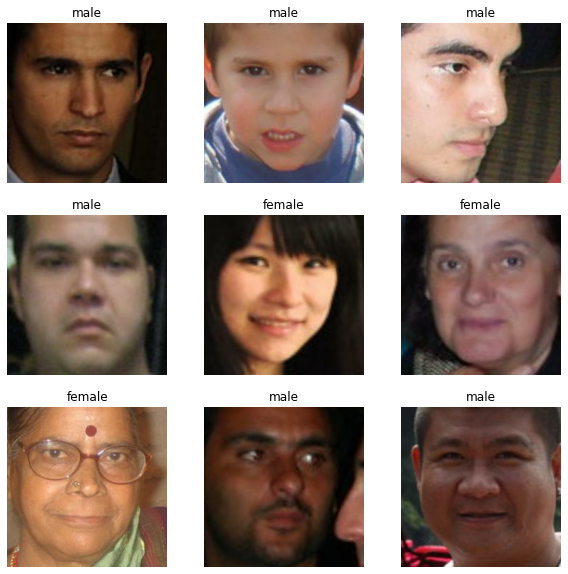

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [8]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

# print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
# print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

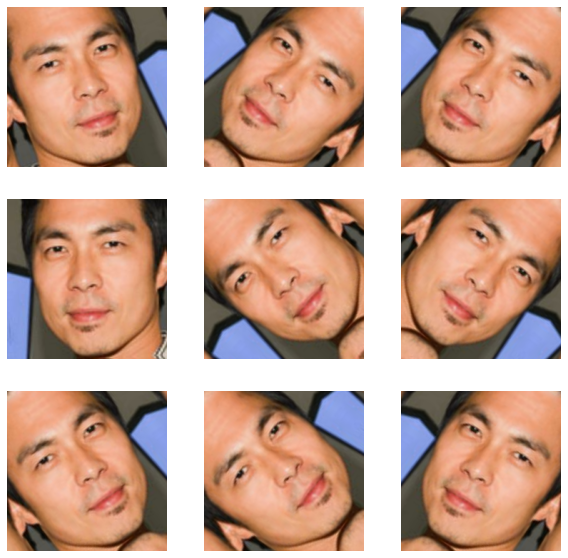

In [11]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [12]:
preprocess_input = tf.keras.applications.densenet.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [13]:
# Create the base model from the pre-trained model DenseNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.densenet.DenseNet201(
               input_shape=IMG_SHAPE,
               include_top=False,
               weights='imagenet'
)

74842112/74836368 [==============================] - 4s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

In [15]:
# Freeze all layers
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1920)


# Beginning of Model Training
## Unperturbed model

In [17]:
# Model creation
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)

In [18]:
x = global_average_layer(x)

In [19]:
x = tf.keras.layers.Dropout(0.2)(x)

In [20]:
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)

In [21]:
outputs = keras.layers.Dense(1,activation='sigmoid')(x)

In [22]:
model = tf.keras.Model(inputs, outputs)

# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

loss0, accuracy0 = model.evaluate(validation_dataset)

259/259 [==============================] - 21s 63ms/step - loss: 0.6961 - accuracy: 0.5157


In [23]:
checkpoint = ModelCheckpoint(
    "model_tl_densenet_best_weights.h5",
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_freq="epoch",
)

# Save a checkpoint of the model for later use
history = model.fit(train_dataset,
                         epochs=EPOCHS,
                         validation_data=validation_dataset,
                        callbacks=[checkpoint])

Epoch 1/500
908/908 [==============================] - 77s 79ms/step - loss: 0.4952 - accuracy: 0.7521 - val_loss: 0.3871 - val_accuracy: 0.8186
Epoch 2/500
908/908 [==============================] - 71s 78ms/step - loss: 0.4511 - accuracy: 0.7793 - val_loss: 0.4010 - val_accuracy: 0.8104
Epoch 3/500
908/908 [==============================] - 71s 78ms/step - loss: 0.4428 - accuracy: 0.7846 - val_loss: 0.3785 - val_accuracy: 0.8284
Epoch 4/500
908/908 [==============================] - 71s 78ms/step - loss: 0.4309 - accuracy: 0.7914 - val_loss: 0.3632 - val_accuracy: 0.8366
Epoch 5/500
908/908 [==============================] - 71s 79ms/step - loss: 0.4250 - accuracy: 0.7975 - val_loss: 0.3571 - val_accuracy: 0.8370
Epoch 6/500
908/908 [==============================] - 71s 78ms/step - loss: 0.4194 - accuracy: 0.8002 - val_loss: 0.3534 - val_accuracy: 0.8384
Epoch 7/500
908/908 [==============================] - 71s 78ms/step - loss: 0.4120 - accuracy: 0.8043 - val_loss: 0.3783 - val_ac

In [24]:
# Store model history as a JSON file
with open(os.path.join("history", "model_tl_densenet_history.json"), "w") as f:
    json.dump(history.history, f) # Construct the baseline (unperturbed) model

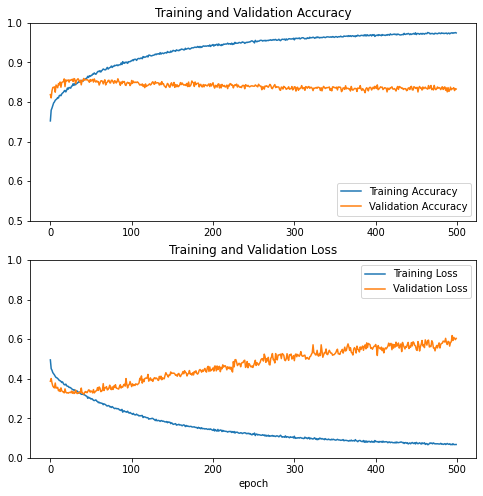

In [25]:
with open('history/model_tl_densenet_history.json') as f:
    st = json.load(f)

acc = []
val_acc = []
loss = []
val_loss = []

acc += st['accuracy']
val_acc += st['val_accuracy']

loss += st['loss']
val_loss += st['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
model = tf.keras.models.load_model('model_tl_densenet_best_weights.h5')

# Model Analysis

In [28]:
test_dataset = image_dataset_from_directory(os.path.join(preprocessing_fp, "test_ori"),
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 4004 files belonging to 2 classes.


In [30]:
for image_batch, label_batch in test_dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten()
        predictions = tf.nn.sigmoid(predictions)
        print("predictions:", predictions)
        predictions = tf.where(predictions < 0.75, 0.5, 1)
        true_labels.extend(label_batch)
        predicted.extend(predictions.numpy())

predictions: tf.Tensor(
[0.5262043  0.73105854 0.5        0.7310354  0.6764725  0.508154
 0.7273803  0.7310562  0.73105824 0.56125057 0.7156465  0.6515831
 0.5183373  0.72593796 0.5004387  0.728075   0.5025865  0.5499563
 0.5002534  0.5089163  0.59218    0.5        0.6658129  0.5
 0.7310207  0.5        0.7309715  0.71856487 0.73105186 0.73105854
 0.6879415  0.50054276], shape=(32,), dtype=float32)


NameError: name 'true_labels' is not defined

In [13]:
# Unravels batches
def unravel_batches(model):
    true_labels = []
    predicted = []
    for image_batch, label_batch in test_dataset.as_numpy_iterator():
        predictions = model.predict_on_batch(image_batch).flatten()
        predictions = tf.nn.sigmoid(predictions)
        predictions = tf.where(predictions < 0.5, 0, 1)
        true_labels.extend(label_batch)
        predicted.extend(predictions.numpy())
        print(predicted)
    return true_labels, predicted

In [14]:
true_labels, predicted = unravel_batches(model)

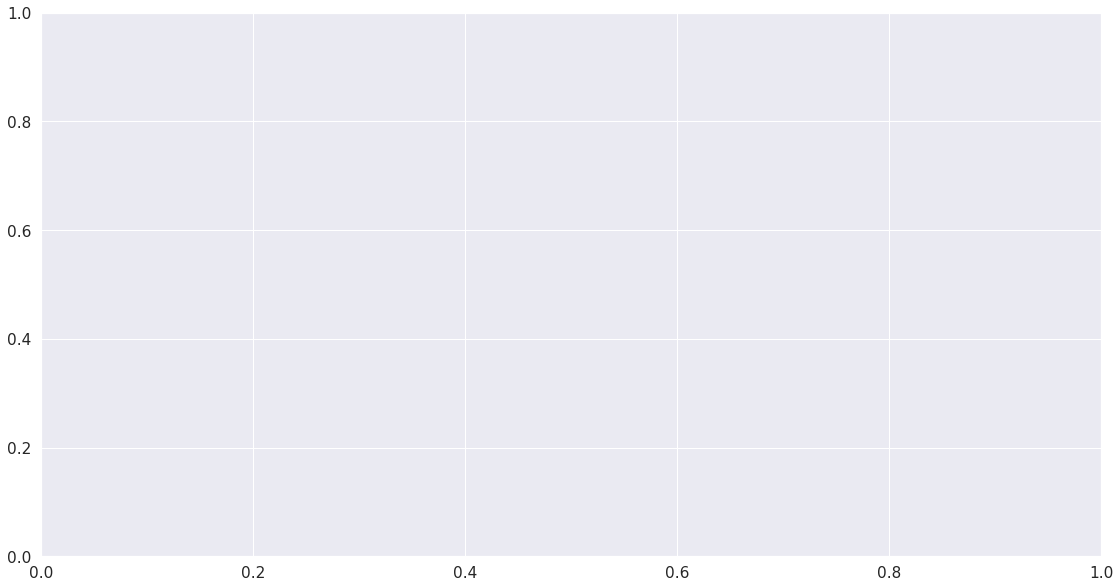

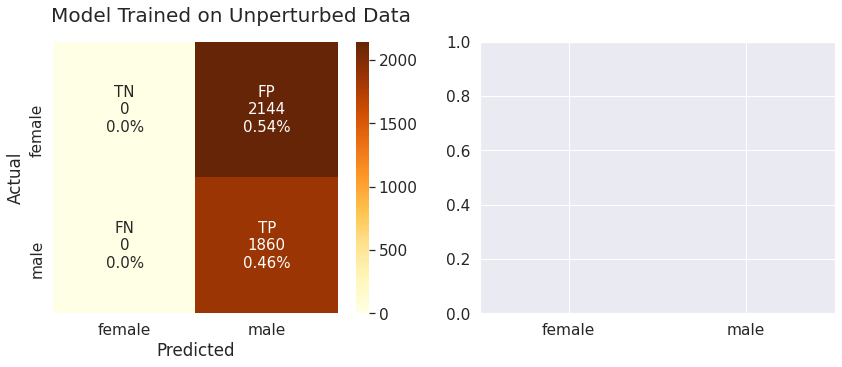

In [32]:
epochs_range = range(EPOCHS)

fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(19, 10))
#fig.suptitle("Unperturbed vs Perturbed")
#fig.subplots_adjust(top=0.85)

cf_matrix = confusion_matrix(true_labels, predicted)

f, ax = plt.subplots(1, 2, sharex=True, figsize=(14, 5))

# Tweak graphs and add text
ext = [
    [72.0 * 2.5, 97.04347826086959 * 2.25],
    [188.4521739130435 * 2.25, 97.04347826086956 * 2.25],
    [304.904347826087 * 2.4, 97.04347826086956 * 2.4],
    [421.35652173913047 * 2.4, 97.04347826086962 * 2.4],
]

inv = fig.transFigure.inverted()
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2.0
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2.0
right_center = inv.transform((width_right, 1))

# Unperturbed data
group_names = ["TN", "FP", "FN", "TP"]
group_counts = map(round, cf_matrix.flatten())
group_percentages = (
    f"{round(value, 2)}%" for value in cf_matrix.flatten() / np.sum(cf_matrix)
)
df_cm = pd.DataFrame(cf_matrix, range(2), range(2))
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"
labels = np.asarray(
    ["\n".join(map(str, v)) for v in zip(group_names, group_counts, group_percentages)]
).reshape(2, 2)

# Confusion matrix titles
width_left = ext[0][0] + (ext[1][0] + ext[1][1] - ext[0][0]) / 2
left_center = inv.transform((width_left, 1))
width_right = ext[2][0] + (ext[3][0] + ext[3][1] - ext[2][0]) / 2
right_center = inv.transform((width_right, 1))
plt.figtext(
    left_center[0],
    0.95,
    "Model Trained on Unperturbed Data",
    va="center",
    ha="center",
    size=20,
)

sns.set(font_scale=1.4)  # for label size
sns.heatmap(
    df_cm,
    annot=labels,
    annot_kws={"size": 15},
    cmap="YlOrBr",
    fmt="",
    ax=ax[0],
    xticklabels=LABELS,
    yticklabels=LABELS,
)
sns.set_style("darkgrid")
plt.show()

In [33]:
print(classification_report(
        true_labels, predicted, target_names=LABELS, zero_division=1
    )
)

              precision    recall  f1-score   support

      female       1.00      0.00      0.00      2144
        male       0.46      1.00      0.63      1860

    accuracy                           0.46      4004
   macro avg       0.73      0.50      0.32      4004
weighted avg       0.75      0.46      0.29      4004

